In [ ]:
# descargamos el dataset
# 2785 imagenes de 300x300 etiquetadas, 58 categorias
!gdown 1Hqe8nS2gGVTZELCC5eW-hsHOyWtFULD0
!unzip dataset.zip

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

def show_img(img_path, label):
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")
    plt.show()

label_dir = os.path.join(os.getcwd(), "dataset", "labels.csv")
dataset_dir = os.path.join(os.getcwd(), "dataset", "images")

LABELS = ["" for _ in range(len(os.listdir(dataset_dir)))]
with open(label_dir) as f:
    f.readline()
    for line in f.readlines():
        img_name, label = line.strip().split(",")
        img_id  = img_name.split(".")[0]
        LABELS[int(img_id)] = label

# visualizamos algunas imagenes del dataset
for img_id in random.sample(range(len(LABELS)), 3):
    img_path = os.path.join(dataset_dir, f"{img_id}.jpg")
    show_img(img_path, LABELS[img_id])



In [26]:
from sklearn.model_selection import train_test_split

# Separamos el dataset en train y test
all_images = os.listdir(dataset_dir)
labels_dict = {i: label for i, label in enumerate(LABELS)}

train_test_split = train_test_split(all_images, test_size=0.2, random_state=1)
train_images, test_images = train_test_split
train_labels = [labels_dict[int(img_id.split(".")[0])] for img_id in train_images]
test_labels = [labels_dict[int(img_id.split(".")[0])] for img_id in test_images]

{0: 'SSG 08 | Blood in the Water', 1: 'SSG 08 | Blood in the Water', 2: 'SSG 08 | Blood in the Water', 3: 'SSG 08 | Blood in the Water', 4: 'SSG 08 | Blood in the Water', 5: 'SSG 08 | Blood in the Water', 6: 'SSG 08 | Blood in the Water', 7: 'SSG 08 | Blood in the Water', 8: 'SSG 08 | Blood in the Water', 9: 'SSG 08 | Blood in the Water', 10: 'SSG 08 | Blood in the Water', 11: 'SSG 08 | Blood in the Water', 12: 'SSG 08 | Blood in the Water', 13: 'SSG 08 | Blood in the Water', 14: 'SSG 08 | Blood in the Water', 15: 'SSG 08 | Blood in the Water', 16: 'SSG 08 | Blood in the Water', 17: 'SSG 08 | Blood in the Water', 18: 'SSG 08 | Blood in the Water', 19: 'SSG 08 | Blood in the Water', 20: 'SSG 08 | Blood in the Water', 21: 'SSG 08 | Blood in the Water', 22: 'SSG 08 | Blood in the Water', 23: 'SSG 08 | Blood in the Water', 24: 'SSG 08 | Blood in the Water', 25: 'SSG 08 | Blood in the Water', 26: 'Galil AR | Aqua Terrace', 27: 'Galil AR | Aqua Terrace', 28: 'Galil AR | Aqua Terrace', 29: 'G

Calcularemos deep features para cada imagen del dataset con el modelo preentrenado ResNet.

In [27]:
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet50
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cargamos el modelo preentrenado ResNet
model = resnet50(pretrained=True)
model.to(device)
model.eval()  # Setearlo en modo evaluacion, para que no se actualicen los pesos

# Convertimos al input esperado por el modelo
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def extract_features(image_path):
    image = Image.open(image_path).convert("RGB")
    image = preprocess(image).unsqueeze(0).to(device)  # Add a batch dimension and move the image to the device
    features = model(image)  # Pass the image through the model to get the deep features
    return features.detach().cpu().numpy().flatten()  # Convert the features to a numpy array

# Calculamos las deep features del set de train
features = []
for img_id in train_images:
    img_path = os.path.join(dataset_dir, img_id)
    features.append(extract_features(img_path))

/home/matias/projects/csgo-skin-identifier/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/matias/projects/csgo-skin-identifier/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Ahora que ya tenemos descriptores para cada imagen del conjunto de entrenamiento, podemos usar estos descriptores para entrenar un clasificador KNN.

In [51]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

# Debemos convertir los labels a numeros
unique_labels = set(LABELS)
label2num = {label: i for i, label in enumerate(unique_labels)}
num2label = {i: label for i, label in enumerate(unique_labels)}

train_labels_num = np.array([label2num[label] for label in train_labels])

knn_classifier = KNeighborsClassifier(n_neighbors=11)
knn_classifier.fit(np.array(features), train_labels_num)


KNeighborsClassifier(n_neighbors=11)

In [52]:
# Calculamos las deep features del set de test
test_features = []
for img_id in test_images:
    img_path = os.path.join(dataset_dir, img_id)
    test_features.append(extract_features(img_path))


In [53]:
test_labels_num = np.array([label2num[label] for label in test_labels])
# Predecimos las labels del set de test
pred_labels_num = knn_classifier.predict(np.array(test_features))

In [ ]:
# Calculamos el accuracy
acc = np.sum(pred_labels_num == test_labels_num) / len(test_labels_num)
print(f"Accuracy: {acc}")

# Vemos el accuracy al clasificar solo el arma (sin la skin)
pred_labels = [num2label[l] for l in pred_labels_num]
pred_weapons = [label.split("|")[0].strip() for label in pred_labels]
test_weapons = [label.split("|")[0].strip() for label in test_labels]
acc2 = np.sum(np.array(pred_weapons) == np.array(test_weapons)) / len(test_weapons)
print(f"Accuracy (solo arma): {acc2}")




# Mostramos algunas predicciones
for img_id in random.sample(range(len(test_images)), 10):
    img_path = os.path.join(dataset_dir, test_images[img_id])
    show_img(img_path, f"Pred: {num2label[pred_labels_num[img_id]]} | Real: {test_labels[img_id]}")

Ahora en vez de usar el modelo solo para extraer descriptores, lo usaremos para extraer descriptores y para clasificar.

In [101]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import os

class CSGOSkinsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = sorted(os.listdir(root_dir), key=lambda x: int(x.split(".")[0])) 
        self.labels = [label2num[l] for l in LABELS]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = os.path.join(self.root_dir, self.image_paths[idx])
        image = Image.open(image_path).convert("RGB")
        if self.transform is not None:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

csgo_dataset = CSGOSkinsDataset(dataset_dir, transform=preprocess)

In [ ]:
# Separamos el dataset en train y test
train_size = int(0.8 * len(csgo_dataset))
test_size = len(csgo_dataset) - train_size
train_dataset, test_dataset = random_split(csgo_dataset, [train_size, test_size])

print(len(train_dataset), len(test_dataset))
# lets print the filenames of the test dataset



for i in range(len(train_dataset)):
    print(test_dataset.indices[i])

train_dataloader = DataLoader(train_dataset, batch_size=20, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=20, shuffle=False)

In [ ]:
# mostremos algunas imagenes del dataset de entrenamiento
cnt = 0
for [img, label] in train_dataset:
    if cnt == 3:
        break
    label = num2label[label]
    print(f"Label: {label}")
    plt.imshow(img.permute(1, 2, 0))
    plt.show()
    cnt += 1

In [127]:
# Load the pretrained ResNet-50 model
model = resnet50(pretrained=True)
model.to(device)

# La capa fully connected clasificará nuestras 58 skins
model.fc = nn.Linear(model.fc.in_features, 58)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

epochs = 7
for epoch in range(epochs):
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}")



/home/matias/projects/csgo-skin-identifier/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/matias/projects/csgo-skin-identifier/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/7], Loss: 3.7917
Epoch [2/7], Loss: 2.2752
Epoch [3/7], Loss: 1.0660
Epoch [4/7], Loss: 0.5135
Epoch [5/7], Loss: 0.2851
Epoch [6/7], Loss: 0.1632
Epoch [7/7], Loss: 0.1051


In [150]:
model.eval()
correct = 0
total = 0
predicted_labels = []
real_labels = [] 
filenames = [] 

with torch.no_grad():
    for i in range(len(test_dataset)):
        img, label = test_dataset[i]
        inputs = img.unsqueeze(0).to(device)
        labels = torch.tensor([label]).to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        predicted_labels.append(str(predicted.item()))
        real_labels.append(str(labels.item()))

        # Guardamos el nombre de la imagen para mostrarla después
        file_id = test_dataset.indices[i]
        filenames.append(file_id)

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")



Test Accuracy: 0.9946


1674


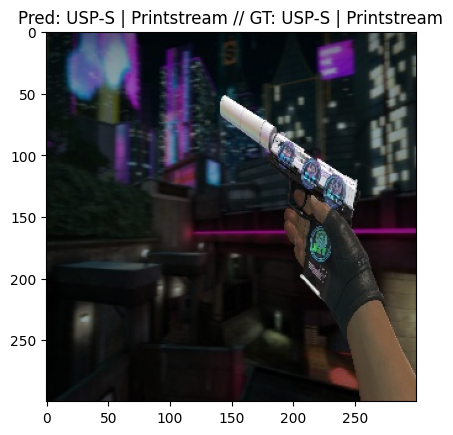

991


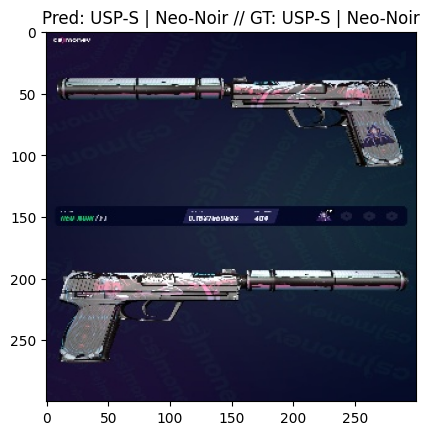

1025


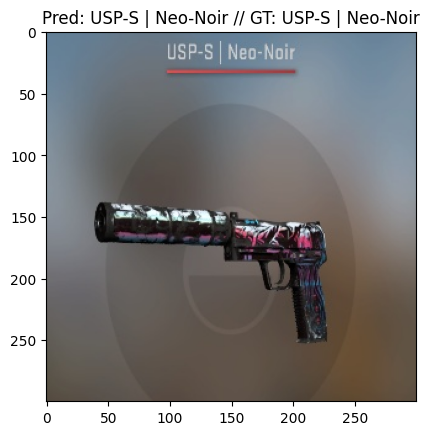

345


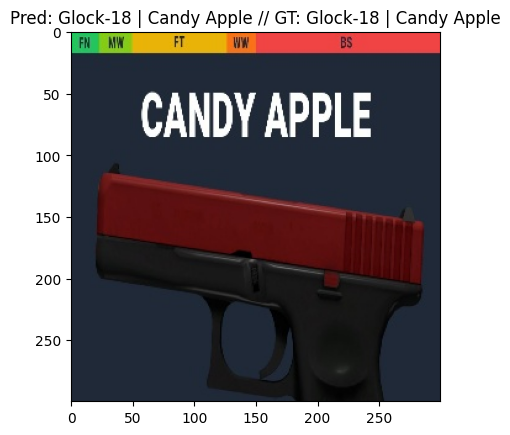

1392


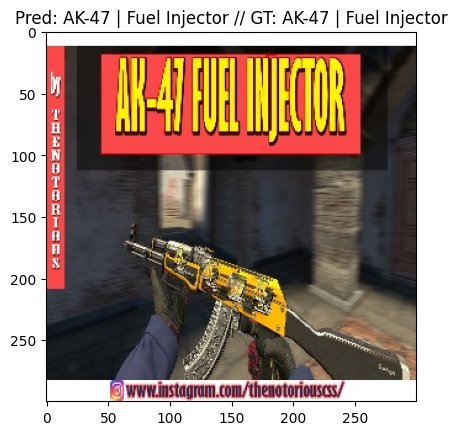

In [153]:
# Visualizamos algunas predicciones
for file_id, predicted_label, true_label in random.sample(list(zip(filenames, predicted_labels, real_labels)), 5):
    img_path = os.path.join(dataset_dir, f"{file_id}.jpg")
    print(file_id)
    title = f"Pred: {num2label[int(predicted_label)]} // GT: {num2label[int(true_label)]}"
    show_img(img_path, title)

In [ ]:
import requests
# Podemos descargar una imagen de internet y predecir su label
def predict_image_label(img_url: str):
    # Descargamos la imagen
    try:
        img_data = requests.get(img_url).content
    except:
        print("Error when downloading image")
        return
    img_path = os.path.join(os.getcwd(), "test.jpg")
    with open(img_path, "wb") as f:
        f.write(img_data)

    img = Image.open(img_path).convert("RGB")
    img = preprocess(img).unsqueeze(0).to(device)
    outputs = model(img)
    _, predicted = torch.max(outputs.data, 1)
    prediction = num2label[predicted.item()]
    # Visualizamos la imagen
    show_img(img_path, prediction)
    return prediction




Probamos el modelo con algunas imágenes sacadas de internet. Observamos que confundió el "AWP | Asiimov" con el "AK-47 | Asiimov", dos armas distintas pero que tienen la misma skin.

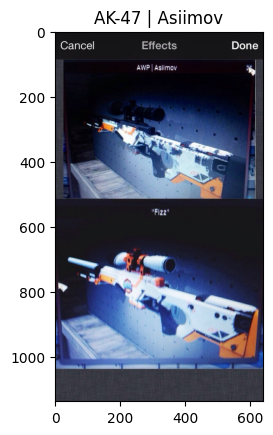

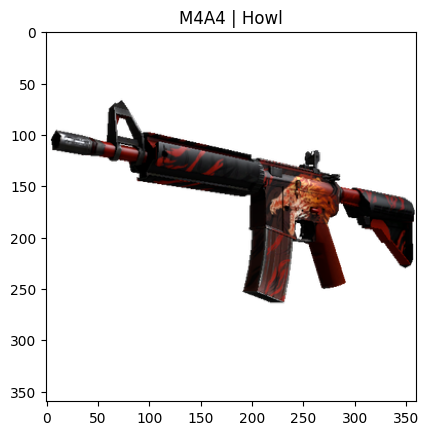

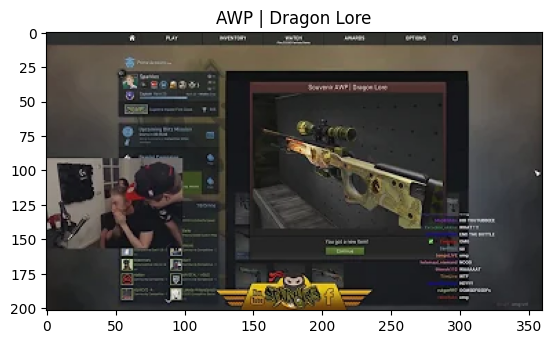

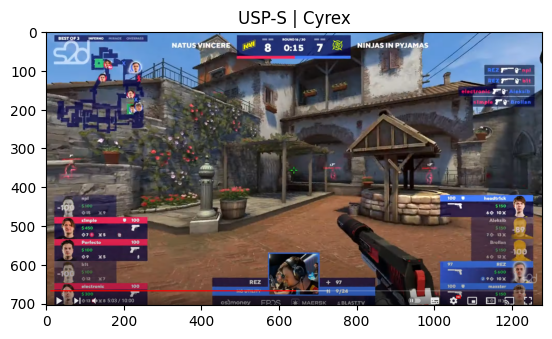

'USP-S | Cyrex'

In [159]:
awp_asiimov = "https://external-preview.redd.it/GcjXL9cE0PZDFeJA47xGSmypr89FBwavw37zhKruhk0.jpg?auto=webp&s=0424d0435fbb8700c0f7553887b671e8b9461a3e"
predict_image_label(awp_asiimov)

m4a4_howl = "https://community.akamai.steamstatic.com/economy/image/-9a81dlWLwJ2UUGcVs_nsVtzdOEdtWwKGZZLQHTxDZ7I56KU0Zwwo4NUX4oFJZEHLbXH5ApeO4YmlhxYQknCRvCo04DEVlxkKgpou-6kejhjxszFJTwT09S5g4yCmfDLP7LWnn9u5MRjjeyP9tqhiQ2yqEo6Mmn3doPBcwZqZQrRr1O-we_sgMO5tZ_BzCFr6ycltmGdwULa1vGJFg/360fx360f"
predict_image_label(m4a4_howl)

# thumbnail de youtube
awp_dragon_lore = "https://i.ytimg.com/vi/CEzFs2xDd9s/hq720.jpg?sqp=-oaymwEcCOgCEMoBSFXyq4qpAw4IARUAAIhCGAFwAcABBg==&rs=AOn4CLAjXqMWd5TC9lSWcOE4Q0mAUzGwgw"
predict_image_label(awp_dragon_lore)

# screenshot de una partida profesional
usp_cyrex = "https://i.imgur.com/43ZuSDa.png"
predict_image_label(usp_cyrex)

